In [8]:
import numpy as np
from scipy.optimize import minimize_scalar

In [9]:
def linear_model(x, a, b):
    return a * x + b
def rational_model(x, a, b):
    return a / (1 + b * (x+1e-9))

In [48]:
def loss(f,x, y,a, b):
    return np.sum((f(x, a, b) - y) ** 2)

In [223]:
def my_steep_des(model, x, y, init_a, init_b, trueab, eps2=1e-3, eps=1e-6, maxiter=200):
    def check(nowab, trueab, eps2):
        return np.linalg.norm(nowab - trueab) < eps2

    a1, b1 = init_a, init_b

    # initial directional step (same as before)
    d_f_a = (loss(model, x, y, a1 + eps, b1) - loss(model, x, y, a1 - eps, b1)) / (2 * eps)
    d_f_b = (loss(model, x, y, a1, b1 + eps) - loss(model, x, y, a1, b1 - eps)) / (2 * eps)

    res = minimize_scalar(lambda alpha: loss(model, x, y, a1 - alpha * d_f_a, b1 - alpha * d_f_b),
                          bounds=(0, 1), method='bounded')
    first_beta = res.x
    a2 = a1 - first_beta * d_f_a
    b2 = b1 - first_beta * d_f_b

    it = 0
    while it < maxiter:
        it += 1
        print(a1, b1)
        d_f_a1 = (loss(model, x, y, a1 + eps, b1) - loss(model, x, y, a1 - eps, b1)) / (2 * eps)
        d_f_b1 = (loss(model, x, y, a1, b1 + eps) - loss(model, x, y, a1, b1 - eps)) / (2 * eps)
        d_f_a2 = (loss(model, x, y, a2 + eps, b2) - loss(model, x, y, a2 - eps, b2)) / (2 * eps)
        d_f_b2 = (loss(model, x, y, a2, b2 + eps) - loss(model, x, y, a2, b2 - eps)) / (2 * eps)

        df1 = np.array([d_f_a1, d_f_b1])
        df2 = np.array([d_f_a2, d_f_b2])
        AB1 = np.array([a1, b1])
        AB2 = np.array([a2, b2])

        S = AB2 - AB1
        DF = df2 - df1

        denom = np.dot(DF, DF)
        if denom == 0 or np.isclose(denom, 0.0):
            # No curvature information; stop or fallback to small gradient step
            beta = 0.0
        else:
            beta = abs(np.dot(S, DF)) / denom

        # guard beta magnitude
        beta = np.clip(beta, 0.0, 1e6)

        AB_next = AB2 - beta * df2

        # check for numerical issues
        if not np.isfinite(AB_next).all():
            # fallback: small gradient step and break if still bad
            AB_next = AB2 - 1e-3 * df2
            if not np.isfinite(AB_next).all():
                break

        a1, b1 = a2, b2
        a2, b2 = AB_next[0], AB_next[1]

        if check(np.array([a2, b2]), trueab, eps2):
            break

    return a2, b2, loss(model, x, y, a2, b2)


In [234]:
def gra_des(model, x, y, init_a, init_b, trueab, eps2=1e-3, flag=1, eps=1e-6, maxiter=200):
    def check(nowab, trueab, eps2):
        return np.linalg.norm(nowab - trueab) < eps2

    a0, b0 = init_a, init_b

    # Initial gradient
    dfa0 = (loss(model, x, y, a0 + eps, b0) - loss(model, x, y, a0 - eps, b0)) / (2 * eps)
    dfb0 = (loss(model, x, y, a0, b0 + eps) - loss(model, x, y, a0, b0 - eps)) / (2 * eps)

    d_a0 = np.array([-dfa0, -dfb0])
    res = minimize_scalar(lambda alpha: loss(model, x, y, a0 + alpha * d_a0[0], b0 + alpha * d_a0[1]),
                          bounds=(0, 1), method='bounded')
    alpha = res.x
    a1 = a0 + alpha * d_a0[0]
    b1 = b0 + alpha * d_a0[1]

    DF_old = d_a0
    s0 = DF_old

    it = 0
    while it < maxiter:
        it += 1
        print(a0, b0)
        dfa_new = -(loss(model, x, y, a1 + eps, b1) - loss(model, x, y, a1 - eps, b1)) / (2 * eps)
        dfb_new = -(loss(model, x, y, a1, b1 + eps) - loss(model, x, y, a1, b1 - eps)) / (2 * eps)
        DF_new = np.array([dfa_new, dfb_new])

        if check(np.array([a1, b1]), trueab, eps2):
            break

        denom = np.dot(DF_old, DF_old)
        if np.isclose(denom, 0.0):
            # fallback: use small FR-like beta = 0 and small step
            beta_FR = 0.0
        else:
            beta_FR = np.dot(DF_new, DF_new) / denom

        denom_pr = np.dot(DF_old, DF_old)
        if np.isclose(denom_pr, 0.0):
            beta_PR = 0.0
        else:
            beta_PR = abs(np.dot(DF_new, DF_new - DF_old) / denom_pr)

        beta_new = beta_FR * flag + beta_PR * (1 - flag)

        # guard beta magnitude and NaNs
        if not np.isfinite(beta_new):
            beta_new = 0.0
        beta_new = float(np.clip(beta_new, -1e6, 1e6))

        s_new = DF_new + beta_new * s0

        # line search along s_new (ensure it's finite)
        if not np.isfinite(s_new).all():
            # fallback to small negative gradient step
            s_new = DF_new
        res = minimize_scalar(lambda alpha: loss(model, x, y, a1 + alpha * s_new[0], b1 + alpha * s_new[1]),
                              bounds=(0, 1), method='bounded')

        a0, b0 = a1, b1
        a1 = a1 + res.x * s_new[0]
        b1 = b1 + res.x * s_new[1]

        DF_old = DF_new
        s0 = s_new

        # optional convergence by parameter change
        if np.linalg.norm(np.array([a1, b1]) - np.array([a0, b0])) < eps2:
            break

    return a1, b1, loss(model, x, y, a1, b1)


In [235]:
def myNewton(model, x, y, init_a, init_b, eps2=1e-6, eps=1e-6, maxiter=100):
    def check(nowab, oldab, tol):
        return np.linalg.norm(nowab - oldab) < tol

    a1 = float(init_a)
    b1 = float(init_b)

    for it in range(maxiter):
        print (a1,b1,loss(model, x, y, a1, b1))
        dfa = (loss(model, x, y, a1 + eps, b1) - loss(model, x, y, a1 - eps, b1)) / (2 * eps)
        dfb = (loss(model, x, y, a1, b1 + eps) - loss(model, x, y, a1, b1 - eps)) / (2 * eps)
        grad = np.array([dfa, dfb])

        ddfa = (loss(model, x, y, a1 + eps, b1) + loss(model, x, y, a1 - eps, b1)
                - 2 * loss(model, x, y, a1, b1)) / (eps * eps)
        ddfb = (loss(model, x, y, a1, b1 + eps) + loss(model, x, y, a1, b1 - eps)
                - 2 * loss(model, x, y, a1, b1)) / (eps * eps)

        ddfab = (
            loss(model, x, y, a1 + eps, b1 + eps)
            - loss(model, x, y, a1 + eps, b1 - eps)
            - loss(model, x, y, a1 - eps, b1 + eps)
            + loss(model, x, y, a1 - eps, b1 - eps)
        ) / (4 * eps * eps)

        H = np.array([[ddfa, ddfab],
                      [ddfab, ddfb]])

        try:
            p = np.linalg.solve(H, grad)
        except np.linalg.LinAlgError:
            step = 1e-3
            a_new = a1 - step * grad[0]
            b_new = b1 - step * grad[1]
            old_ab = np.array([a1, b1])
            a1, b1 = a_new, b_new
            if check(np.array([a1, b1]), old_ab, eps2):
                break
            continue

        old_ab = np.array([a1, b1])
        a1 = a1 - p[0]
        b1 = b1 - p[1]
        if check(np.array([a1, b1]), old_ab, eps2):
            break

    return a1, b1, loss(model, x, y, a1, b1)

In [236]:
def lm_fit(model, x, y, init_a, init_b,
           eps_fd=1e-6, tol=1e-6, maxiter=200,
           lambda0=1e-3, lambda_up=10.0, lambda_down=0.1):

    def residual(a, b):
        return model(x, a, b) - y

    def jacobian(a, b):
        fa_plus = model(x, a + eps_fd, b)
        fa_minus = model(x, a - eps_fd, b)
        fb_plus = model(x, a, b + eps_fd)
        fb_minus = model(x, a, b - eps_fd)
        Jr_a = (fa_plus - fa_minus) / (2 * eps_fd)
        Jr_b = (fb_plus - fb_minus) / (2 * eps_fd)
        J = np.vstack([Jr_a, Jr_b]).T
        return J

    a = float(init_a)
    b = float(init_b)
    lam = float(lambda0)

    hist = []
    r = residual(a, b)
    loss = 0.5 * np.dot(r, r)

    for it in range(1, maxiter + 1):
        J = jacobian(a, b)
        JTJ = J.T @ J
        JTr = J.T @ r

        D = np.diag(np.diag(JTJ))
        A = JTJ + lam * D

        try:
            delta = np.linalg.solve(A, -JTr)
        except np.linalg.LinAlgError:
            lam *= lambda_up
            hist.append((it, a, b, loss, lam))
            continue

        a_new = a + delta[0]
        b_new = b + delta[1]

        r_new = residual(a_new, b_new)
        loss_new = 0.5 * np.dot(r_new, r_new)

        if loss_new < loss:
            a, b, r, loss = a_new, b_new, r_new, loss_new
            lam = max(lam * lambda_down, 1e-16)
        else:
            lam = lam * lambda_up

        hist.append((it, a, b, loss, lam))

        if np.linalg.norm(delta) < tol:
            break
        if abs(loss_new - loss) < tol:
            break

    return a, b, loss, hist

In [252]:
np.random.seed(23)
alpha = np.random.rand()
beta = np.random.rand()
k = np.arange(101)
x = k / 100
delta = np.random.normal(0, 1, size=len(x))
y = alpha * x + beta + delta*1
trueab=np.array([alpha,beta])
model=rational_model
print (alpha)
print (beta)



0.5172978838465893
0.9469626038148141


In [249]:
a,b,final_loss=my_steep_des(model,x,y,-200, 76,trueab)
a,b,final_loss=gra_des(model,x,y,-200, 76,trueab,eps2=1e-3,flag=1)
a,b,final_loss=myNewton(model,x,y,1, 2)
a, b, final_loss, _ = lm_fit(model, x, y, init_a=0.0, init_b=0.0)
print (a,b,final_loss)

-200 76
-196.39197451167072 85.4438620219259
-183.81012346967276 114.22514451056662
-166.56630025363637 141.8747676469647
-134.81944620662546 179.0397825187646
-82.61226567159319 218.26317291908825
5.258923675706129 251.46035409001396
131.05420426759386 248.8337771140239
168.27165741885716 229.2642044158155
279.2792998431465 147.9322137714653
353.3043070837746 8.559116744768062
349.7181344723359 149.687659560456
349.73904075625757 149.63894555577713
398.5290355293392 35.90903144403981
388.1462587133883 149.78002739094765
389.5250821632965 146.21633467066326
438.95058481843 14.901383127539845
434.31777687854515 147.631188698401
434.3736106584649 147.46736841171017
488.6277950013678 -11.915156461842884
484.90838343682566 -169.9741122798031
484.8639029644194 -170.10131483448095
460.456273758832 -239.84204780706347
432.9980452933548 -292.64733626237785
377.597026938472 -374.7328210515561
289.4636569230757 -463.63663660190235
136.75039660764364 -559.0644567870719
-109.86785554537212 -619.43

-200 76
-52.27030523451748 134.29098616487653
-52.18745490877068 134.08101453867172
-23.120762537046932 60.72191502721395
0.8623778220629426 0.19339509201963523
0.7294143575881606 0.1407124038814272
0.8621694927011039 0.193313277529237
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19331327753897454
0.8621694927059727 0.19

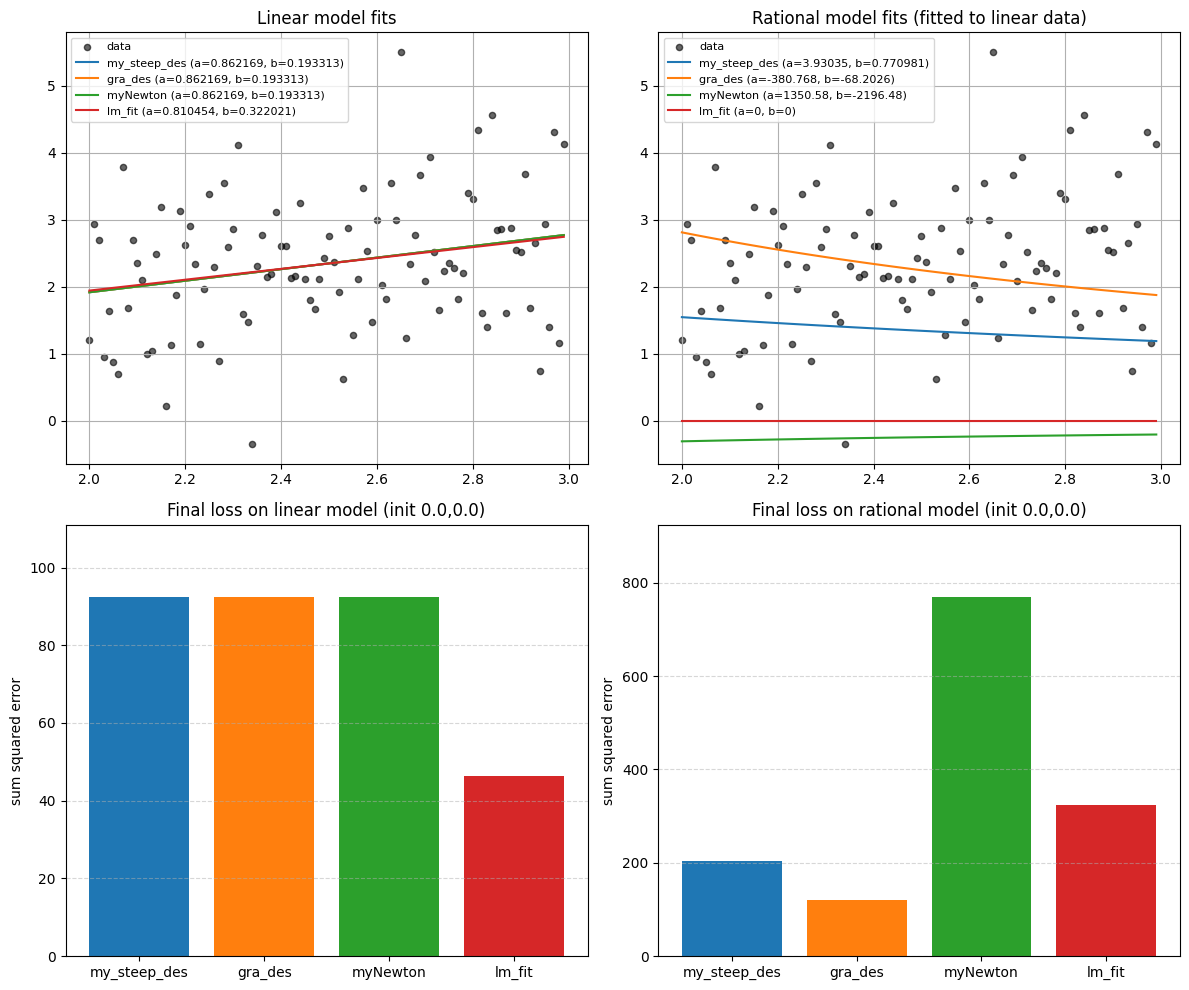


Comparison table (init 0.0,0.0):

Model      Alg          success           a          b           loss
linear     my_steep_des OK         0.862169   0.193313        92.5143
linear     gra_des      OK         0.862169   0.193313        92.5143
linear     myNewton     OK         0.862169   0.193313        92.5143
linear     lm_fit       OK         0.810454   0.322021        46.2683
rational   my_steep_des OK          3.93035   0.770981        203.456
rational   gra_des      OK         -380.768   -68.2026        120.072
rational   myNewton     OK          1350.58   -2196.48        770.345
rational   lm_fit       OK                0          0        324.171


In [250]:
import matplotlib.pyplot as plt
import numpy as np


# ensure previous functions are in scope: linear_model, rational_model,
# my_steep_des, gra_des, myNewton, lm_fit, loss, x, y, trueab

# helper to call safely (catch exceptions and return diagnostics)
def run_and_report(alg, model_fn, x, y, init_a, init_b, trueab):
    name = alg.__name__
    try:
        if name in ("my_steep_des", "gra_des"):
            a, b, L = alg(model_fn, x, y, init_a, init_b, trueab)
        else:
            # myNewton and lm_fit signatures differ slightly
            if name == "myNewton":
                a, b, L = alg(model_fn, x, y, init_a, init_b)
            elif name == "lm_fit":
                a, b, L, hist = alg(model_fn, x, y, init_a, init_b)
            else:
                # fallback
                a, b, L = alg(model_fn, x, y, init_a, init_b)
        info = {"success": True, "a": float(a), "b": float(b), "loss": float(L)}
        # include history if lm_fit returned it
        if name == "lm_fit":
            info["hist"] = hist
    except Exception as e:
        info = {"success": False, "error": str(e)}
    return info


# algorithms to compare (in order)
algs = [my_steep_des, gra_des, myNewton, lm_fit]

# initial guesses to use for both models
inits = [(-200, 76), (0.0, 0.0), (1.0, 1.0)]

# store results: results[model_name][alg_name] = info
results = {"linear": {}, "rational": {}}

# run for linear_model
for alg in algs:
    for init in inits:
        key = f"{alg.__name__}_init{init[0]}_{init[1]}"
        info = run_and_report(alg, linear_model, x, y, init[0], init[1], trueab)
        results["linear"][key] = info

# run for rational_model (keep same y produced by linear true model so it's a mismatch test)
for alg in algs:
    for init in inits:
        key = f"{alg.__name__}_init{init[0]}_{init[1]}"
        info = run_and_report(alg, rational_model, x, y, init[0], init[1], trueab)
        results["rational"][key] = info


# Helper to compute fitted curve and formatted string
def fitted_curve_and_text(model_fn, a, b):
    yhat = model_fn(x, a, b)
    return yhat, f"a={a:.6g}, b={b:.6g}"


# Plotting
plt.close("all")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# 1) Data + fits for linear_model (subplot 0)
ax = axes[0]
ax.scatter(x, y, s=20, label="data", color="k", alpha=0.6)
for key, info in results["linear"].items():
    if not info["success"]:
        continue
    alg_name = key.split("_init")[0]
    # plot only one result per algorithm (the last init) for clarity: pick the init (0.0,0.0) if present
    if "_init0.0_0.0" not in key:
        continue
    yhat, txt = fitted_curve_and_text(linear_model, info["a"], info["b"])
    ax.plot(x, yhat, label=f"{alg_name} ({txt})")
ax.set_title("Linear model fits")
ax.legend(fontsize=8)
ax.grid(True)

# 2) Data + fits for rational_model (subplot 1)
ax = axes[1]
ax.scatter(x, y, s=20, label="data", color="k", alpha=0.6)
for key, info in results["rational"].items():
    if not info["success"]:
        continue
    if "_init0.0_0.0" not in key:
        continue
    yhat, txt = fitted_curve_and_text(rational_model, info["a"], info["b"])
    ax.plot(x, yhat, label=f"{key.split('_init')[0]} ({txt})")
ax.set_title("Rational model fits (fitted to linear data)")
ax.legend(fontsize=8)
ax.grid(True)

# 3) Bar chart of final losses for linear_model (subplot 2)
ax = axes[2]
labels = []
losses = []
for key, info in results["linear"].items():
    if not info["success"]:
        continue
    # show only one init to keep chart readable
    if "_init0.0_0.0" not in key:
        continue
    labels.append(key.split("_init")[0])
    losses.append(info["loss"])
ax.bar(labels, losses, color=["C0", "C1", "C2", "C3"])
ax.set_title("Final loss on linear model (init 0.0,0.0)")
ax.set_ylabel("sum squared error")
ax.set_ylim(0, max(losses) * 1.2 if losses else 1)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# 4) Bar chart of final losses for rational_model (subplot 3)
ax = axes[3]
labels = []
losses = []
for key, info in results["rational"].items():
    if not info["success"]:
        continue
    if "_init0.0_0.0" not in key:
        continue
    labels.append(key.split("_init")[0])
    losses.append(info["loss"])
ax.bar(labels, losses, color=["C0", "C1", "C2", "C3"])
ax.set_title("Final loss on rational model (init 0.0,0.0)")
ax.set_ylabel("sum squared error")
ax.set_ylim(0, max(losses) * 1.2 if losses else 1)
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Print a compact comparison table (for init 0.0,0.0)
print("\nComparison table (init 0.0,0.0):\n")
print(f"{'Model':<10} {'Alg':<12} {'success':<8} {'a':>10} {'b':>10} {'loss':>14}")
for model_name in ("linear", "rational"):
    for key, info in results[model_name].items():
        if "_init0.0_0.0" not in key:
            continue
        alg_name = key.split("_init")[0]
        if not info["success"]:
            print(f"{model_name:<10} {alg_name:<12} {'FAIL':<8} {'-':>10} {'-':>10} {info['error']!s:>14}")
        else:
            print(f"{model_name:<10} {alg_name:<12} {'OK':<8} {info['a']:10.6g} {info['b']:10.6g} {info['loss']:14.6g}")
